In [1]:
# ☯ Coding Dojo ☯

<img style="float:left" src="imgs/vamos_coletar.png">
## Regras

Ponto de participação, poderá perdido se:

    - Aluno atrasado (ver política de atraso na especificação)
    - Recusar participação como piloto/copiloto
        - Ou não querer sair do computador, quando solicitado :-)
    - Demorar para sair quando solicitado
    - Parar de participar por:
        - Uso de outro computador
        - Uso de celular
        - Usar a internet
        - Conversa


Antes de entregar, certifique-se que tenha executado todos os comandos/códigos deste Jupyter. É obrigatório que todas as saídas tenham sido apresentadas. Perda de 3 pontos caso não tenham feito isso.

# Dependencias

Se necessário, instale o python3 e o pip3 abaixo usando `sudo apt-get install python3 python3-pip`.  Execute abaixo para instalar o [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/). Qualquer linha de comando/código como a de baixo, você pode executá-la a selecionando e pressionando `ctrl+enter` ❣️.

In [2]:
!pip3 install bs4

Caso de comando não encontrado `pip3` use `pip`. 

# Coletor

<img src="imgs/arquitetura_coletor.png">

Você deverá completar a implementação das três classes abaixo para fazer o coletor: `Domain`, `Scheduler` e `PageFetcher`. Conforme figura acima, o `Scheduler` é responsável por armazenar as filas de URLs a serem requisitadas; o PageFetcher serão *threads* responsáveis por fazer as requisições das URLs obtidas por meio do escalonador (instancia da classe `Scheduler`). A classe `Domain` armazena informações importantes sobre o servidor a serem usadas no momento do escalonamento das URLs.

## Classe `Domain`

<figure style="text-align:center">
    <img src="imgs/estrutura_coletor.png">
    <caption>Fonte: Baeza-Yates e Ribeiro-Neto, 2011 </caption>
</figure>

Antes de começar a fazer o escalonador (classe `Scheduler`) devemos implementar a classe que representa os domínios. Conforme visto na figura acima, o escalonador possuirá diversas filas, uma para cada servidor.  Em nosso caso, o servidor será um domínio - que você irá implementar na classe `Domain` do arquivo `domain.py`. 

O escalonador percorrerá cada servidor e obterá o primeiro da fila do primeiro servidor acessível. O servidor é acessível obdecendo o limite de tempo entre requisições (em segundos, usando o atributo `int_time_limit_between_requests`). 

Nesta atividade você irá implementar a classe `Domain`, que já possui os seguintes atributos: 

- *int_time_limit_between_requests*: Limite entre requisições (int)
- *nam_domain*: Nome do domínio (String)
- *time_last_access*: [Objeto Datetime](https://docs.python.org/3/library/datetime.html#datetime-objects) informando da data/hora do último acesso 

O prefixo da variável sempre irá denotar o tipo da mesma.

**Atividade 1 - classe `Domain`**: Complete a classe `Domain` implementando os métodos/atributos calculados descritos a seguir. Logo após, execute o ❣️ teste unitário ❣️ para verificar se os métodos/atributos calculados foram implementados conforme esperado.

- **accessed_now**: Método que modifica o último acesso com a data/hora atual usando um [objeto datetime](https://docs.python.org/3/library/datetime.html#datetime-objects)
- **time_since_last_access**: Atributo calculado que retorna um [objeto TimeDelta](https://docs.python.org/3/library/datetime.html#timedelta-objects) com a diferença da data atual e a data do último acesso. Veja os exemplos de uso do TimeDelta na sua documentação
- **is_accessible**: Método que verdadeiro se o domínio estiver acessível

Os métodos `count_fetched_page` e `has_finished_crawl` já estão implementados. Execute o teste unitário a seguir. Veja que o comando abaixo executa o teste unitário presente no arquivo `crawler/scheduler_test.py`. Analise-o para entender como implementamos testes unitários.

In [3]:
!python3 -m crawler.scheduler_test DomainTest.test_domain

Verificando acesso a um dominio já requisitado (após espera)
aguardando 10 segundos...
.
----------------------------------------------------------------------
Ran 1 test in 10.008s

OK


**Atividade 2 - métodos `__hash__` e `__eq__` da classe `Domain`**: A fila será implementada por um dicionario ordenado ([OrderedDict](https://docs.python.org/2/library/collections.html#collections.OrderedDict)) em que a chave será um objeto da classe domínio e o valor serão uma lista de URLs. Para que seja possível a busca do domínio, você deverá implementar os métodos `__hash__` e `__eq__` de forma similar ao seguinte exemplo: 

In [4]:
from collections import OrderedDict
class Xuxu():
    def __str__(self):
        return "xuxuuu"
    
    def __hash__(self):
        return hash("xuxu")
    def __eq__(self, x):
        return x == "xuxu"
d = OrderedDict()
d[Xuxu()] = 'A'
print("xuxu" in d)

True


Em nosso caso, deve ser permitido fazer a busca no dicionario pelo nome do domínio ou pelo objeto, ou seja, após a implementação desta atividade, o seguinte código irá funcionar corretamente: 

In [5]:
from crawler.domain import Domain
from collections import OrderedDict

obj_domain = Domain("oi.com",10)
dic_x = OrderedDict()
dic_x[obj_domain] = "lala"
dic_x["oi.com"] = "oi"

#abaixo, em ambos os casos, será encontrado/impresso a string "oi"
print(dic_x["oi.com"])
print(dic_x[obj_domain])

oi
oi


Lembre-se que, em nosso caso, o parametro do método `__eq__` pode ser um objeto da classe `Domain` ou uma string representando o nome do domínio. Caso faça alguma modificação no código, você deverá reiniciar o kernel para que o efeito seja visto no código acima (para reiniciar, clique em Kernel->Restart). Isso ocorre que, uma vez dado import em um módulo, esse modulo não é alterado no Jupyter caso você faça uma modificação no código.

## Classe `Scheduler`

Agora você irá implementar o escalonador. Essa classe será responsável por gerenciar as URLs. 
Para isso, será implementado as filas por servidores conforme apresentado na figura da seção anterior. 
Para isso, utilizaremos um OrderedDict em que as chaves são os servidores (objeto da classe `Domain`) e o valor será uma lista de tuplas com as URLs e sua profundidade. Com o objetivo de armazenar as URLs de forma estruturada, as mesmas **não serão** string, ao invés disso, serão objetos da classe `ParseResult` - essa classe é retornada do método [urlparse](https://docs.python.org/3/library/urllib.parse.html). Veja um exemplo abaixo.



In [6]:
from crawler.domain import Domain
from crawler.scheduler import Scheduler
from urllib.parse import urlparse

dict_filas_por_servidor = {Domain("www.globo.com",10):[(urlparse("http://www.globo.com/esporte"),1),
                                                (urlparse("http://www.globo.com/noticia_um"),2),
                                                (urlparse("http://www.globo.com/noticia_dois"),3),
                                                (urlparse("http://www.globo.com/noticia_tres"),3),
                                                ],
                            Domain("www.cnpq.br",10):[(urlparse("http://www.cnpq.br/pesquisadores"),1),
                                               (urlparse("http://www.cnpq.br/bolsas"),1)]
                          }

Assim, a classe `Scheduler`, no arquivo `scheduler.py` possui os seguintes atributos: 

- `str_usr_agent`: Nome do `User agent`. Usualmente, é o nome do navegador, em nosso caso,  será o nome do coletor (usualmente, terminado em `bot`)
- `int_page_limit`: Número de páginas a serem coletadas
- `int_depth_limit`: Profundidade máxima a ser coletada
- `int_page_count`: Quantidade de página já coletada
- `dic_url_per_domain`: Fila de URLs por domínio (explicado anteriormente)
- `set_discovered_urls`: Conjunto de URLs descobertas, ou seja, que foi extraída em algum HTML e já adicionadas na fila - mesmo se já ela foi retirada da fila. A URL armazenada deve ser uma string.
- `dic_robots_per_domain`: Dicionário armazenando, para cada domínio, o objeto representando as regras obtidas no `robots.txt`

**Atividad 3 - Método `can_add_page`**: Esse método irá retornar verdadeiro caso seja possível adicionar a página `obj_url` (objeto da classe ParseResult) que foi coletada na profundidade `int_depth`. Para que seja possível adicionar na lista, esta pagina não deve ter sido descoberta e nem com a profundidade maior que o limite. Este método será testado por teste unitário apenas após a implementação da adição e obtenção das URLs.

**Atividade 4 método `add_new_page` - Adicionar nova página**:  Este método retorna falso caso não seja possível adicionar a página (por meio do método `can_add_page`) e verdadeiro, caso contrário. Caso seja possível, deve-se adicionar a url `obj_url` na fila `dic_url_per_domain`. Lembre-se da estrutura do dicionário `dic_url_per_domain`. Não esqueça de armazenar que esta URL já foi descoberta. Este método será testado por teste unitário apenas após a implementação da obtenção das URLs. Lembre-se de como trabalhar com [dicionários](https://daniel-hasan.github.io/cefet-web-grad/classes/python2/#mais-colecoes)

**Atividade 5 método `get_next_url` - obtém a próxima URL da fila**: Este método retona uma tupla `url,profundade` da próxima URL a ser coletada por meio da fila `dic_url_per_domain` retirando este item da fila. Lembre-se que: 
    
- Ele deverá retornar a primeira URL do primeiro servidor que estiver acessível. 
- Você deve indicar que o servidor foi acessado 
- Caso a fila deste servidor esteja vazia, elimine-o do dicionário
- Caso não encontre a URL, [coloque a Thread para esperar](https://docs.python.org/2/library/time.html#time.sleep) e, logo após, procure novamente 

Logo após, você já pode executar o teste unitário para verificar se a obtenção e adição de URLs está correta. Caso haja algum problema, existem já alguns prints comentados no código, descomente-os para verificar se o fluxo está ocorrendo da forma correta. Você deverá entregar sem a exibição desses prints (caso contrário, perderá pontos).

In [7]:
!python3 -m crawler.scheduler_test SchedulerTest.test_add_remove_pages

Verificação da ordem das URLs...
Resgatando a segunda página do mesmo dominio...
Tempo esperado: 20 segundos
.
----------------------------------------------------------------------
Ran 1 test in 20.021s

OK


**Atividade 6 método `can_fetch_page`**: Este método deve retornar verdadeiro caso a url (Objeto `ParseResult`), passada como parâmetro, pode ser coletada de acordo com o `Robots.txt` do domínio. Para isso, você deve usar o [`RobotFileParser`](https://docs.python.org/3/library/urllib.robotparser.html). Por razões de performance, você só poderá requisitar o robots.txt uma única vez por domínio. Assim, use o `dic_robots_per_domain` apropriadamente. Execute o teste unitário abaixo para verificar seu funcionamento. 

In [8]:
!python3 -m crawler.scheduler_test SchedulerTest.test_can_fetch_page

E
ERROR: test_can_fetch_page (__main__.SchedulerTest)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/home/natha/CEFET/crawlerRI/tp-crawler/crawler/scheduler_test.py", line 88, in test_can_fetch_page
    obj_robot_not_allowed = self.scheduler.dic_robots_per_domain[obj_url_not_allowed.netloc]
KeyError: 'www.globo.com'

----------------------------------------------------------------------
Ran 1 test in 1.995s

FAILED (errors=1)


**Atividade 7 - Inicialização das sementes no contrutor**: No contrutor da classe `Scheduler` você deve adicionar as páginas sementes na fila. Tais sementes são passadas pelo parametro `arr_urls_seeds` do contrutor. 

In [9]:
!python3 -m crawler.scheduler_test SchedulerTest.test_init

.
----------------------------------------------------------------------
Ran 1 test in 0.000s

OK


Logo após, utize a anotação @synchronized aonde julgar necessário para transformar em ThreadSafe.

## PageFetcher

**Atividade 8 - Efetuar a requisição - método `request_url`:** Neste método você irá fazer a requisição usando a api [requests](https://requests.readthedocs.io/en/master/). Além disso, deve-se informar no cabeçalho (em `User-Agent`) o nome do coletor. O método deverá retornar o conteúdo (em binário) apenas se o conteúdo for HTML (ver no cabeçalho da resposta o tipo do conteúdo). Caso não seja, ele deverá retornar nulo. 

In [10]:
!python3 -m crawler.page_fetcher_test PageFetcherTest.test_request_url

URL do request: http://www.google.com.br
URL do request: https://code.jquery.com/jquery-3.4.1.js
.
----------------------------------------------------------------------
Ran 1 test in 0.571s

OK


**Atividade 9 extração das URLs por meio do método `discover_links`**: A partir do conteúdo (texto em binário) `bin_str_content` deve-se extrair seus os links. O conteúdo esta em binário, pois, o BeautifulSoup, internamente, verifica o encoding por meio da [tag meta](https://www.w3schools.com/tags/att_meta_charset.asp) e converte para UTF8. A URL da página coletada é um objeto ParseResult `obj_url` que está na profundidade `int_depth`. 

Para cada URL extraída, você deverá retornar uma tupla com a URL (objeto ParseResult) e a sua profundidade. Utilize o comando `yield` para retornar essas tuplas. A profundidade é calculada de por meio de  `obj_url` e `int_depth`, conforme comentado em sala de aula. 

Para a extração dos links, use o [CSS Selector do BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#css-selectors). Seletor CSS é uma expressão que define quais elementos HTML serão estilizados pelo CSS. No *Beatifulsoup* eles são usados para selecionar quais tags serão extraídas. Veja o exemplo de uso e brinque abaixo. Caso precise, veja aqui um pouco de seletores CSS: [slides de Web](https://fegemo.github.io/cefet-front-end/classes/css2/#outros-seletores), [documentação MDN](https://developer.mozilla.org/en-US/docs/Web/CSS/CSS_Selectors).

In [11]:
from bs4 import BeautifulSoup



In [12]:
!python3 -m crawler.page_fetcher_test PageFetcherTest.test_discover_links

Simulação da extração de links da página http://www.pudim.com.br na profundidade nível 2...
.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


**Atividade 10 - método que solicita uma nova URL**: Por meio do método `crawl_new_url` você deverá utilizar os métodos previamente implementados para:

- Solicitar ao escalonador uma nova URL
- Fazer a requisição e obter o resultado (em binário)
- Caso a URL seja um HTML válido, imprima esta URL e extraia os seus links

**Atividade 12 - método run**: Este método deve coletar páginas enquanto a coleta não foi finalizada

**Atividade 11 - um pequeno teste para finalizar: ** Use as sementes do seu grupo e crie abaixo um escalonador e 5 PageFetchers para extrair 30 páginas. Imprima também o tempo gasto total.

In [1]:
from crawler.scheduler import Scheduler
from crawler.page_fetcher import PageFetcher
from datetime import datetime

arr_urls_seeds = ["http://www.crea-mg.org.br","https://www.cefetmg.br","https://youtube.com"]
scheduler = Scheduler(str_usr_agent="CrawlerBot(nathaclmpaulino.github.io/crawlerRI/infoCrawlerBot)", int_page_limit=30, int_depth_limit=3, arr_urls_seeds=arr_urls_seeds)

pf1 = PageFetcher(scheduler)
pf2 = PageFetcher(scheduler)
pf3 = PageFetcher(scheduler)
pf4 = PageFetcher(scheduler)
pf5 = PageFetcher(scheduler)

start = datetime.now()

pf1.run()
pf2.run()
pf3.run()
pf4.run()
pf5.run()

end = datetime.now()
diff = end - start

print('Tempo de coleta: ' + str(diff.total_seconds()))

http://www.crea-mg.org.br
https://www.cefetmg.br
https://youtube.com
https://www.copeve.cefetmg.br/processos/20202_SUP
https://youtu.be/OJKxWMLX3I0
http://www.eng-automacao.araxa.cefetmg.br/
http://www.eng-minas.araxa.cefetmg.br/
http://www.administracao.bh.cefetmg.br/
http://www.eng-computacao.bh.cefetmg.br/
http://www.eng-eletrica.bh.cefetmg.br
http://www.eng-mecanica.bh.cefetmg.br/
http://www.eng-civil.bh.cefetmg.br/
http://www.eng-ambiental.bh.cefetmg.br/
http://www.eng-materiais.bh.cefetmg.br/
http://www.eng-transportes.bh.cefetmg.br/
http://www.letras.bh.cefetmg.br/
http://www.quimicatecnologica.bh.cefetmg.br/
http://www.eng-civil.curvelo.cefetmg.br/
http://www.designdemoda.divinopolis.cefetmg.br/
http://www.eng-computacao.divinopolis.cefetmg.br/
http://www.eng-mecatronica.divinopolis.cefetmg.br/
http://www.eng-computacao.leopoldina.cefetmg.br/
http://www.eng-controleautomacao.leopoldina.cefetmg.br/
http://www.eng-eletrica.nepomuceno.cefetmg.br/
http://www.eng-computacao.timoteo.

In [1]:
from crawler.scheduler import Scheduler
from crawler.page_fetcher import PageFetcher
from datetime import datetime
import pandas as pd

list_start = []
list_end   = []
list_diff  = []

def run_fetchers(int_thread_number, scheduler):
    lista = []
    for i in range(int_thread_number):
        lista.append(PageFetcher(scheduler))
    
    start = datetime.now()
    for i in range(int_thread_number):
        lista[i].run()
    end = datetime.now()
    
    exectime = end - start
    
    list_start.append(start)
    list_end.append(end)
    list_diff.append(exectime.total_seconds())

    

arr_urls_seeds = ["http://www.crea-mg.org.br","https://www.cefetmg.br","https://kubernetes.io/"]
scheduler1 = Scheduler(str_usr_agent="CrawlerBot(nathaclmpaulino.github.io/crawlerRI/infoCrawlerBot)", int_page_limit=500, int_depth_limit=6, arr_urls_seeds=arr_urls_seeds)
scheduler2 = Scheduler(str_usr_agent="CrawlerBot(nathaclmpaulino.github.io/crawlerRI/infoCrawlerBot)", int_page_limit=500, int_depth_limit=6, arr_urls_seeds=arr_urls_seeds)
scheduler3 = Scheduler(str_usr_agent="CrawlerBot(nathaclmpaulino.github.io/crawlerRI/infoCrawlerBot)", int_page_limit=500, int_depth_limit=6, arr_urls_seeds=arr_urls_seeds)
scheduler4 = Scheduler(str_usr_agent="CrawlerBot(nathaclmpaulino.github.io/crawlerRI/infoCrawlerBot)", int_page_limit=500, int_depth_limit=6, arr_urls_seeds=arr_urls_seeds)
scheduler5 = Scheduler(str_usr_agent="CrawlerBot(nathaclmpaulino.github.io/crawlerRI/infoCrawlerBot)", int_page_limit=500, int_depth_limit=6, arr_urls_seeds=arr_urls_seeds)
scheduler6 = Scheduler(str_usr_agent="CrawlerBot(nathaclmpaulino.github.io/crawlerRI/infoCrawlerBot)", int_page_limit=500, int_depth_limit=6, arr_urls_seeds=arr_urls_seeds)

run_fetchers(10, scheduler1)
print('Done - 10')
run_fetchers(30, scheduler2)
print('Done - 30')
run_fetchers(50, scheduler3)
print('Done - 50')
run_fetchers(70, scheduler4)
print('Done - 70')
run_fetchers(90, scheduler5)
print('Done - 90')
run_fetchers(100, scheduler6)
print('Done - 100')



https://www.cefetmg.br
https://youtu.be/OJKxWMLX3I0
https://www.google.com.br/intl/pt-BR/policies/privacy/
https://www.cefetmg.br/
https://youtu.be//t/contact_us
http://www.cefetmg.br/home-page/
https://youtu.be//t/terms
https://email.cefetmg.br/
https://www.cefetmg.br/instituicao/
https://www.cefetmg.br/instituicao/historia/
https://youtu.be//new
https://www.facebook.com/cefetmg
https://www.instagram.com/cefetmg/
http://l.facebook.com/l.php?u=http%3A%2F%2Fshare.here.com%2Fr%2Fmylocation%2Fe-eyJuYW1lIjoiQ0VGRVQtTUcgLSBDZW50cm8gRmVkZXJhbCBkZSBFZHVjYVx1MDBlN1x1MDBlM28gVGVjbm9sXHUwMGYzZ2ljYSBkZSBNaW5hcyBHZXJhaXMiLCJhZGRyZXNzIjoiQXYuIEFtYXpvbmFzIDUyNTMgLSBOb3ZhIFN1aVx1MDBlN2EsIEJlbG8gSG9yaXpvbnRlLCBNRyIsImxhdGl0dWRlIjotMTkuOTMwMDk0ODIwMDY2LCJsb25naXR1ZGUiOi00My45NzgyODIxNTk5NjQsInByb3ZpZGVyTmFtZSI6ImZhY2Vib29rIiwicHJvdmlkZXJJZCI6MjE0NjIzMjAxODk0NjgwfQ%3D%3D%3Flink%3Daddresses%26fb_locale%3Dpt_BR%26ref%3Dfacebook&h=AT3cKu3NJhT7qUMRHuSR6c71XTz1dK1uHFBsahMe65Bcw8Ri_95ZmlnTG6huQ0LknQdBMBbVx2Kb

In [2]:
list_pages_per_sec = []
for i in range(len(list_diff)):
    list_pages_per_sec.append(500/list_diff[i])

table_threads = pd.DataFrame({'Threads' : ["10", "30", "50", "70", "90", "100"],
                   'Start' : list_start,
                   'End': list_end,
                   'Diff' : list_diff,
                    'Pages per Second': list_pages_per_sec
                       })

table_threads

,Threads,Start,End,Diff,Pages per Second
0,10,2020-10-16 12:40:21.300496,2020-10-16 13:07:00.150439,1598.849943,0.312725
1,30,2020-10-16 13:07:00.150674,2020-10-16 13:35:43.154628,1723.003954,0.290191
2,50,2020-10-16 13:35:43.155104,2020-10-16 14:02:46.019925,1622.864821,0.308097
3,70,2020-10-16 14:02:46.020252,2020-10-16 14:29:11.768272,1585.748020,0.315309
4,90,2020-10-16 14:29:11.769276,2020-10-16 14:55:39.315493,1587.546217,0.314951
5,100,2020-10-16 14:55:39.315781,2020-10-16 15:22:05.571214,1586.255433,0.315208


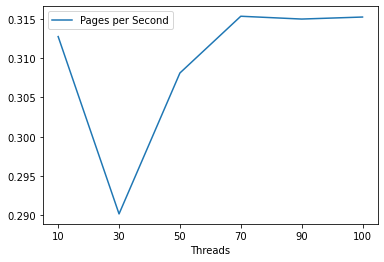

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# gca stands for 'get current axis'
ax = plt.gca()

table_threads.plot(kind='line',x='Threads',y='Pages per Second',ax=ax)

plt.show()

# Bibliografia

Baeza-Yates, Ricardo; Ribeiro-Neto, Berthier. **Modern information retrieval: the concepts and technology behind search**. ACM Press, 2011.

Batista, Natércia ; Brandão, Michele ; Pinheiro, Michele ; Dalip, Daniel ; Moro, Mirella . **[Dados de Múltiplas Fontes da Web: coleta, integração e pré-processamento](https://sol.sbc.org.br/livros/index.php/sbc/catalog/download/8/19/58-1?inline=1)**. Minicursos do XXIV Simpósio Brasileiro de Sistemas Multimídia e Web. 1ed.: Sociedade Brasileira de Computação, 2018, v. , p. 153-192.




